In [1]:
import pandas as pd
import os
import numpy as np
import re
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
# GPU specs

# you can get this from deviceQuery
gpuName = 'NVIDIA RTX 3080'

# you can call nvidia-smi -i 0 -q to see what the clock is set to 
# you can also set the clock with nvidia-smi -lgc 1440,1440 for consistent measurements
# vendor specs show the base clock
baseClockHz = 1.440e9

# find these values here: https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#arithmetic-instructions
SPinstPerCyclePerSM = 128
DPinstPerCyclePerSM = 2
intInstPerCyclePerSM = 64

# find this in deviceQuery or GPU vendor specs
numSMs = 68

# we always assume you're doing FMA -- we should add another roofline for non-FMA
numFMAopPerInst = 2

# conversion multiplier
tflopPerflop = 1e-12

# get this from your GPU vendor specs, mine was 760.3 GB/s
maxBandwidthTBPerSec = 0.7603

spOPMaxPerfTFLOP = SPinstPerCyclePerSM * numSMs * baseClockHz * numFMAopPerInst * tflopPerflop
dpOPMaxPerfTFLOP = DPinstPerCyclePerSM * numSMs * baseClockHz * numFMAopPerInst * tflopPerflop
intOPMaxPerfTFLOP = intInstPerCyclePerSM * numSMs * baseClockHz * numFMAopPerInst * tflopPerflop

spOPMaxPerfTFLOP_noFMA = spOPMaxPerfTFLOP / 2
dpOPMaxPerfTFLOP_noFMA = dpOPMaxPerfTFLOP / 2

print('Max SP TFLOP/s with FMA', round(spOPMaxPerfTFLOP, 3))
print('Max DP TFLOP/s with FMA', round(dpOPMaxPerfTFLOP, 3))
print('Max SP TFLOP/s w/out FMA', round(spOPMaxPerfTFLOP_noFMA, 3))
print('Max DP TFLOP/s w/out FMA', round(dpOPMaxPerfTFLOP_noFMA, 3))
print('Max TINTOP/s', round(intOPMaxPerfTFLOP, 3))

Max SP TFLOP/s with FMA 25.068
Max DP TFLOP/s with FMA 0.392
Max SP TFLOP/s w/out FMA 12.534
Max DP TFLOP/s w/out FMA 0.196
Max TINTOP/s 12.534


### Open the Gathered Data CSV Files

In [3]:
dtypes={'Kernel Name':'string', 
        'traffic':np.float64,
        'dpAI':np.float64,
        'spAI':np.float64,
        'dpPerf':np.float64,
        'spPerf':np.float64,
        'xtime':np.float64,
        'Block Size': 'string',
        'Grid Size': 'string',
        'device': 'string',
        "intops": np.float64, 
        "intPerf" : np.float64,
        "intAI": np.float64,
        'targetName': 'string',
        'exeArgs': 'string',
        'kernelName': 'string',
        }

# we need to gather more data for this dataset
df = pd.read_csv('../roofline-data-new.csv', quotechar='"', dtype=dtypes)

# if we're loading old data that didn't gather intops
#df = pd.read_csv('../roofline-data-OLD-only-cuda.csv', quotechar='"', dtype=dtypes)
#df['intops'] = 0
#df['intPerf'] = 0
#df['intAI'] = 0

df['language'] = df['targetName'].apply(lambda x: 'CUDA' if '-cuda' in x else 'OMP')

print(df.shape)


(2970, 17)


In [4]:
# because a lot of these kernels were sampled twice, let's drop the first sample (which typically runs for longer than the second sample)
#grouped = df.groupby(by=['Kernel Name', 'kernelName', 'targetName', 'exeArgs'])['xtime'].min().reset_index()
#
#print(grouped.head())
#print(grouped.shape)
#
#df = df.merge(grouped, on=list(grouped.columns), how='inner')
# it turns out when we give REGEX to 'ncu' to capture kernels, some kernel names have
# extra characters that also get captured. e.g: AIDW_Kernel and AIDW_Kernel_Tiled both match for the former
df = df.drop_duplicates(subset=['Kernel Name', 'kernelName', 'targetName', 'exeArgs', 'language'])

counts = df.groupby(['language']).count()
print(counts)
print(df.shape)

          Kernel Name  traffic  dpAI  spAI  dpPerf  spPerf  xtime  Block Size  \
language                                                                        
CUDA              887      887   887   887     887     887    887         887   
OMP               700      700   700   700     700     700    700         700   

          Grid Size  device  intops  intPerf  intAI  targetName  exeArgs  \
language                                                                   
CUDA            887     887     887      887    887         887      741   
OMP             700     700     700      700    700         700      579   

          kernelName  
language              
CUDA             887  
OMP              700  
(1587, 17)


In [5]:
print(df.shape)
print(df.columns)
print(df.dtypes)

(1587, 17)
Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language'],
      dtype='object')
Kernel Name    string[python]
traffic               float64
dpAI                  float64
spAI                  float64
dpPerf                float64
spPerf                float64
xtime                 float64
Block Size     string[python]
Grid Size      string[python]
device         string[python]
intops                float64
intPerf               float64
intAI                 float64
targetName     string[python]
exeArgs        string[python]
kernelName     string[python]
language               object
dtype: object


### Let's drop rows with NULL values and fix exeArgs that got a NaN value because they didn't have exeArgs

These were executions that yielded no performance counter data (i.e: they didn't do single/double precision floating point operations).

In [6]:
df = df[df['Kernel Name'].notna()] 

print(df.shape)

# let's also replace exeArgs that are NaN with ''
df['exeArgs'] = df['exeArgs'].fillna('')

(1587, 17)


In [7]:
# how many different kernel invocations did we capture?

totalExes = df.groupby(['targetName', 'device', 'exeArgs']).ngroups
print(f'Total unique executables sampled: {totalExes}')

totalKernels = df.groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Total unique kernel executions recorded: {totalKernels}')

zeroAIKernels = df[(df['spAI'] == 0.0) & (df['dpAI'] == 0.0)].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Number of kernels with no arithmetic intensity (AI) {zeroAIKernels} ({round(100*zeroAIKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero AI single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero Perf single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero Perf double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numIntPerfKernels = df[df['intPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numIntAIKernels = df[df['intAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups


print(f'Number of non-zero Perf intop kernels recorded: {numIntPerfKernels} ({round(100*numIntPerfKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI intop kernels recorded: {numIntAIKernels} ({round(100*numIntAIKernels/totalKernels, 2)}%)')



Total unique executables sampled: 606
Total unique kernel executions recorded: 1587
Number of kernels with no arithmetic intensity (AI) 667 (42.03%)
Number of non-zero AI single-precision kernels recorded: 775 (48.83%)
Number of non-zero AI double-precision kernels recorded: 285 (17.96%)
Number of non-zero Perf single-precision kernels recorded: 775 (48.83%)
Number of non-zero Perf double-precision kernels recorded: 285 (17.96%)
Number of non-zero Perf intop kernels recorded: 1584 (99.81%)
Number of non-zero AI intop kernels recorded: 1584 (99.81%)


In [8]:

#print(df[df['targetName'] == 'bspline-vgh-cuda'])
#df['exeArgs'] = df['exeArgs'].apply(lambda x: '' if x == 'NULL' else x )

#print(df.dtypes)


### Scale the Performance Data

Here we scale down the `spPerf` and `dpPerf` columns to be on the scale of 1e11 (like how it's done in `ncu`).

In [9]:
# scale everything to be in TFLOP/s
df['dpPerf'] = df['dpPerf']*(1e-12)
df['spPerf'] = df['spPerf']*(1e-12)
df['intPerf'] = df['intPerf']*(1e-12)


### Let's plot what we have so far

We have double and single precision FLOP data, so we're going to have two plots.

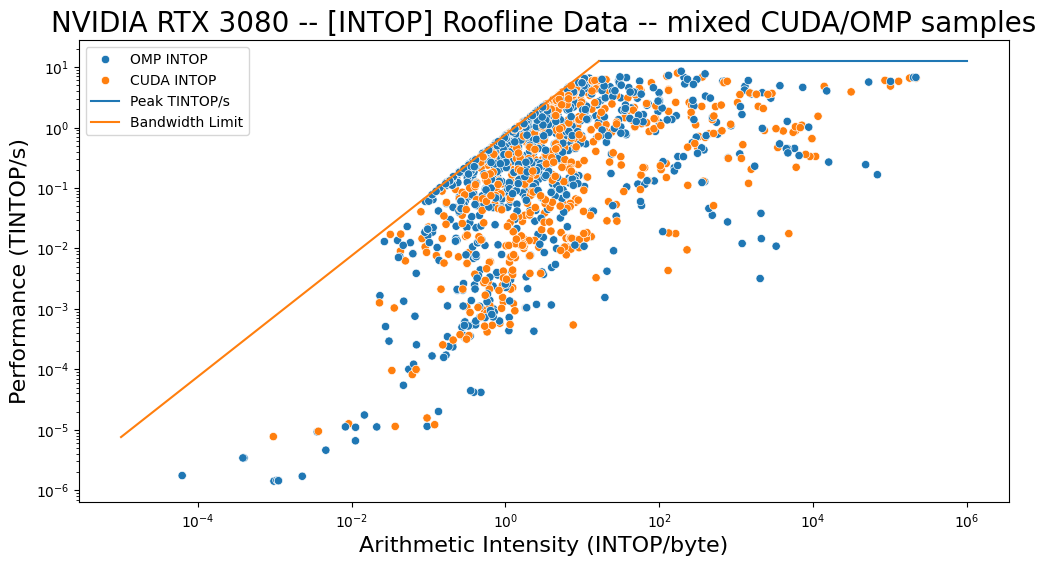

In [10]:
# it should be noted that samples with AI=0 and Perf=0 will not show on this plot

# Interesting question: why does the INTOP data fit the same FLOP roofline??
# are the ALUs for FLOP and INTOP tightly-coupled?

fig, ax = plt.subplots(1, figsize=(12,6))

sns.scatterplot(df, x='intAI', y='intPerf', hue='language', ax=ax)
#sns.scatterplot(df, x='dpAI', y='dpPerf', ax=ax)

# plot the intOPS roofline line
ax.plot([intOPMaxPerfTFLOP/maxBandwidthTBPerSec, 1e6], [intOPMaxPerfTFLOP,intOPMaxPerfTFLOP], label='Peak SP TFLOP/s')

# plot the roofline slanted line
ax.plot([1e-5, intOPMaxPerfTFLOP/maxBandwidthTBPerSec], [maxBandwidthTBPerSec*1e-5,intOPMaxPerfTFLOP], label='Max Bandwidth')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_title(f'{gpuName} -- [INTOP] Roofline Data -- mixed CUDA/OMP samples', fontsize=20)

ax.set_xlabel('Arithmetic Intensity (INTOP/byte)', fontsize=16)
ax.set_ylabel('Performance (TINTOP/s)', fontsize=16)

legend = ax.legend()
legend.labels = ['OMP INTOP', 'CUDA INTOP', 'Peak TINTOP/s', 'Bandwidth Limit']
ax.legend(legend.legend_handles, legend.labels)

plt.show()

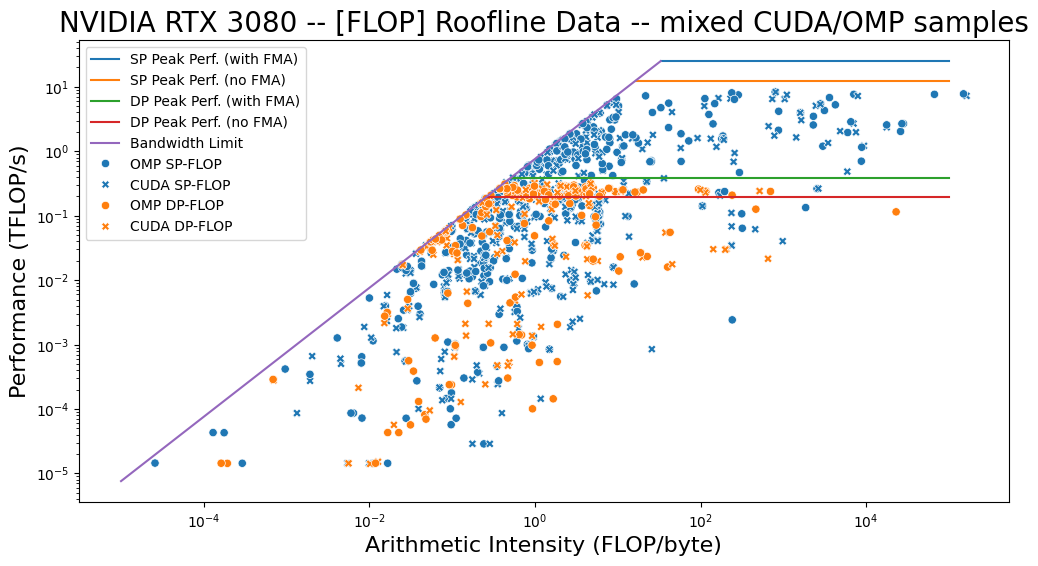

In [11]:
# it should be noted that samples with dpAI=0 and dpPerf=0 will not show on this plot
fig, ax = plt.subplots(1, figsize=(12,6))



# plot the SPOPS roofline line
ax.plot([spOPMaxPerfTFLOP/maxBandwidthTBPerSec, 1e5], [spOPMaxPerfTFLOP,spOPMaxPerfTFLOP], label='Peak SP TFLOP/s (with FMA)')

ax.plot([spOPMaxPerfTFLOP/(2*maxBandwidthTBPerSec), 1e5], [spOPMaxPerfTFLOP/2,spOPMaxPerfTFLOP/2], label='Peak SP TFLOP/s (no FMA)')

# plot the DPOPS roofline line
ax.plot([dpOPMaxPerfTFLOP/maxBandwidthTBPerSec, 1e5], [dpOPMaxPerfTFLOP,dpOPMaxPerfTFLOP], label='Peak DP TFLOP/s (with FMA)')

ax.plot([dpOPMaxPerfTFLOP/(2*maxBandwidthTBPerSec), 1e5], [dpOPMaxPerfTFLOP/2,dpOPMaxPerfTFLOP/2], label='Peak DP TFLOP/s (no FMA)')

# plot the roofline slanted line
ax.plot([1e-5, spOPMaxPerfTFLOP/maxBandwidthTBPerSec], [maxBandwidthTBPerSec*1e-5,spOPMaxPerfTFLOP], label='Max Bandwidth')

sns.scatterplot(df, x='spAI', y='spPerf', ax=ax, style='language')
sns.scatterplot(df, x='dpAI', y='dpPerf', ax=ax, style='language')

ax.set_yscale('log')
ax.set_xscale('log')

#ax.axvline(0.51)
#ax.axvline(32.94)

ax.set_title(f'{gpuName} -- [FLOP] Roofline Data -- mixed CUDA/OMP samples', fontsize=20)

ax.set_xlabel('Arithmetic Intensity (FLOP/byte)', fontsize=16)
ax.set_ylabel('Performance (TFLOP/s)', fontsize=16)

legend = ax.legend()
legend.labels = [ 'SP Peak Perf. (with FMA)', 'SP Peak Perf. (no FMA)', 'DP Peak Perf. (with FMA)', 'DP Peak Perf. (no FMA)', 'Bandwidth Limit', 'OMP SP-FLOP', 'CUDA SP-FLOP', 'OMP DP-FLOP', 'CUDA DP-FLOP']
ax.legend(legend.legend_handles, legend.labels)

plt.show()

Notice how the NVIDIA-reported roofline looks very similar to our rooflines!

Their DP roofline is just under 10e11 FLOP/s (so is ours!) 
Their SP roofline is just above 100e11 FLOP/s -- ours is actually just under 100e11.

We essenitally just performed an empirical roofline gathering! 

### Note
The NVIDIA rooflines are based on empirical data that they seem to gather on-the-fly, as the rooflines seem to change slightly across ncu reports.

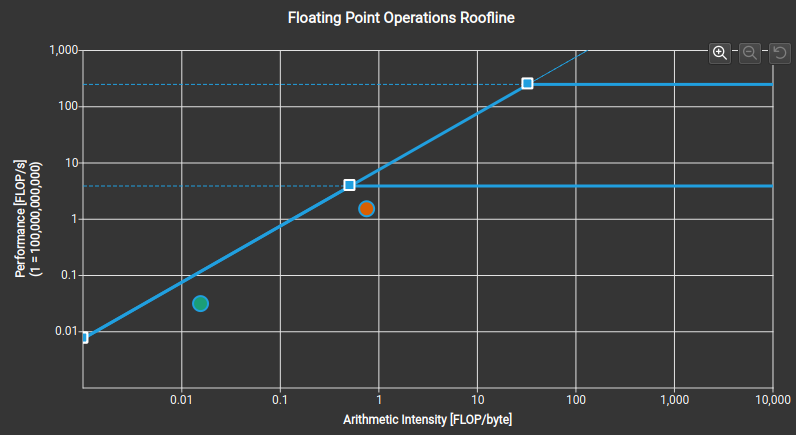

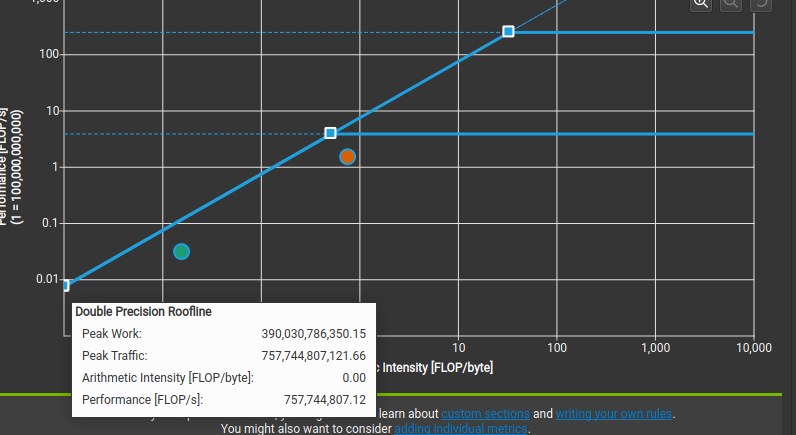

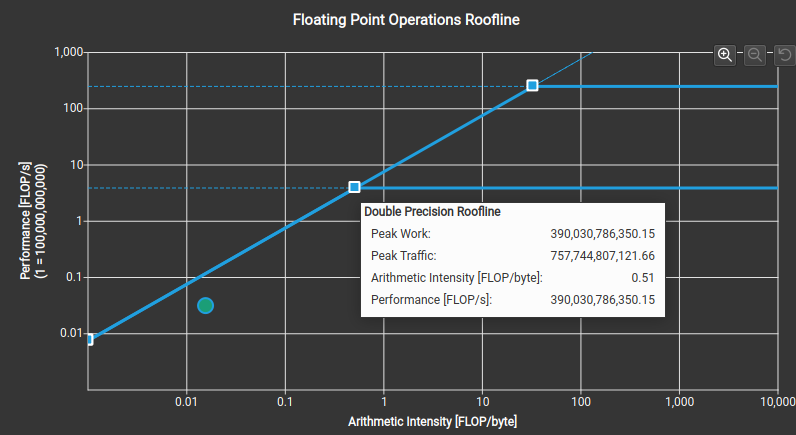

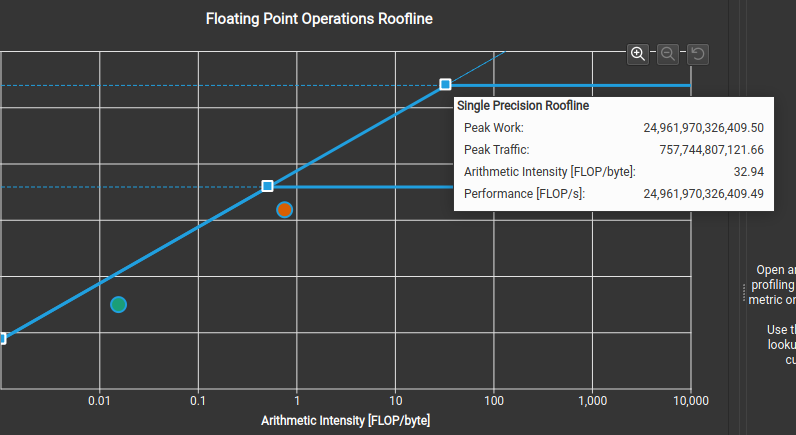

### Let's get some statistics about the data

In [12]:
print(df.columns)


Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language'],
      dtype='object')


In [13]:
# how many different kernel invocations did we capture?
totalExes = df.groupby(['targetName', 'device', 'exeArgs']).ngroups
print(f'Total unique executables sampled: {totalExes}')

totalKernels = df.groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Total unique kernel executions recorded: {totalKernels}')

zeroAIKernels = df[(df['spAI'] == 0.0) & (df['dpAI'] == 0.0)].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Number of kernels with no arithmetic intensity (AI) {zeroAIKernels} ({round(100*zeroAIKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero AI single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero Perf single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero Perf double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numIntPerfKernels = df[df['intPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numIntAIKernels = df[df['intAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups


print(f'Number of non-zero Perf intop kernels recorded: {numIntPerfKernels} ({round(100*numIntPerfKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI intop kernels recorded: {numIntAIKernels} ({round(100*numIntAIKernels/totalKernels, 2)}%)')



Total unique executables sampled: 606
Total unique kernel executions recorded: 1587
Number of kernels with no arithmetic intensity (AI) 667 (42.03%)
Number of non-zero AI single-precision kernels recorded: 775 (48.83%)
Number of non-zero AI double-precision kernels recorded: 285 (17.96%)
Number of non-zero Perf single-precision kernels recorded: 775 (48.83%)
Number of non-zero Perf double-precision kernels recorded: 285 (17.96%)
Number of non-zero Perf intop kernels recorded: 1584 (99.81%)
Number of non-zero AI intop kernels recorded: 1584 (99.81%)


In [14]:
spData = df[(df['spAI'] > 0)]
dpData = df[(df['dpAI'] > 0)]

#subdata = df[(df['spPerf'] > 0) | (df['dpPerf'] > 0) | (df['spAI'] > 0) | (df['dpAI'] > 0) ]
print('SP data')
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].max(axis=0))
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].min(axis=0))
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].median(axis=0))
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].mean(axis=0))

print()
print('DP data')
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].max(axis=0))
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].min(axis=0))
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].median(axis=0))
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].mean(axis=0))

SP data
spPerf         8.331123
dpPerf         0.321496
spAI      163001.600719
dpAI         699.293698
dtype: float64
spPerf    0.000014
dpPerf    0.000000
spAI      0.000026
dpAI      0.000000
dtype: float64
spPerf    0.130318
dpPerf    0.000000
spAI      1.092558
dpAI      0.000000
dtype: float64
spPerf      0.745870
dpPerf      0.030822
spAI      824.965606
dpAI        4.146308
dtype: float64

DP data
spPerf        2.881249
dpPerf        0.321496
spAI       3472.896445
dpAI      23004.943886
dtype: float64
spPerf    0.000000
dpPerf    0.000014
spAI      0.000000
dpAI      0.000162
dtype: float64
spPerf    0.000000
dpPerf    0.088689
spAI      0.000000
dpAI      0.662751
dtype: float64
spPerf     0.069749
dpPerf     0.120760
spAI      28.904687
dpAI      95.940581
dtype: float64


In [15]:

def plotAIHistogram(df, language):
    fig, ax = plt.subplots(1, figsize=(12,6))

    subdf = df[df['language'] == language]

    sns.histplot(subdf, x='intAI', bins=100, ax=ax, log_scale=True)
    sns.histplot(subdf, x='spAI', bins=100, ax=ax, log_scale=True)
    sns.histplot(subdf, x='dpAI', bins=100, ax=ax, log_scale=True)
    ax2 = ax.twinx()
    sns.ecdfplot(subdf, x='intAI', ax=ax2)
    sns.ecdfplot(subdf, x='spAI', ax=ax2)
    sns.ecdfplot(subdf, x='dpAI', ax=ax2)

    ax.set_xlabel('Arithmetic Intensity (TeraOP/byte)')
    ax.set_ylabel('Number of Kernels')
    ax2.set_ylabel('Proportion of Total Kernels')

    ax.set_title(f'{gpuName} -- Non-zero Arithmetic Intensity {language} Kernels Distribution')

    ax.legend(['INTOP', 'Single-Precision FLOP', 'Double-Precision FLOP'])

    plt.show()

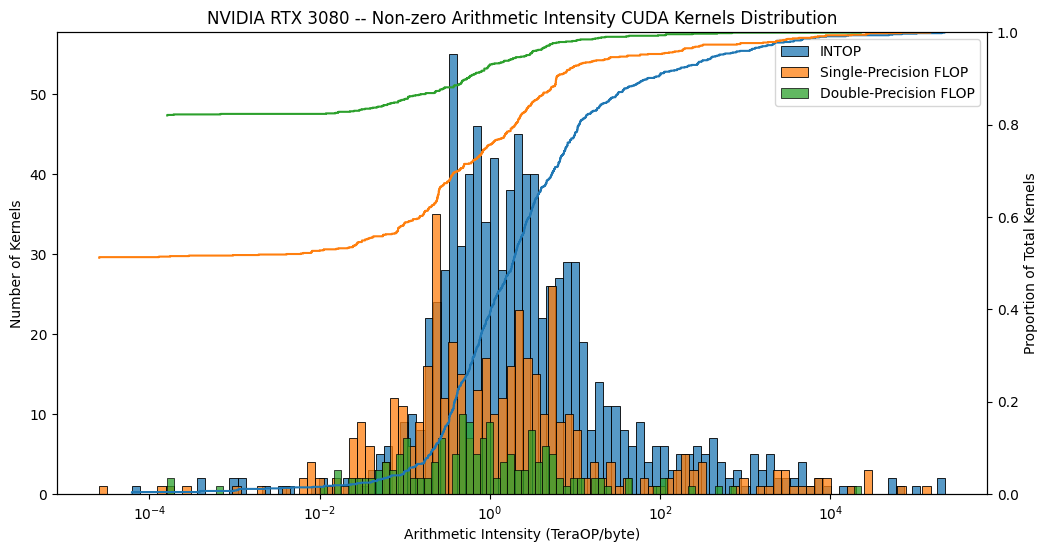

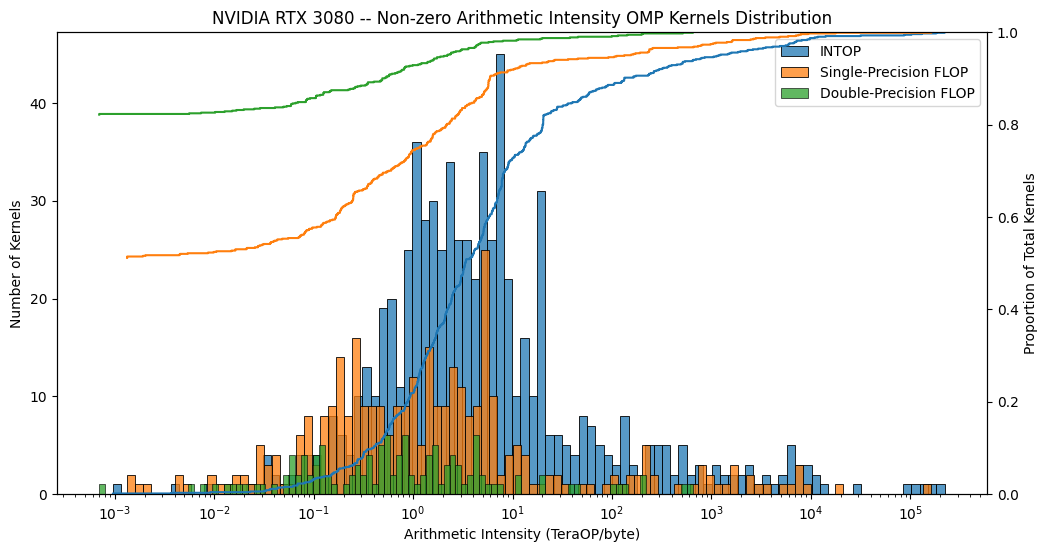

In [16]:
plotAIHistogram(df, 'CUDA')
plotAIHistogram(df, 'OMP')

In [17]:
#subdf = df[df['targetName'].isin(['bspline-vgh-cuda'])].copy().reset_index()
#
#print(subdf)
#
#print(type(subdf.iloc[0]['exeArgs']))
#
#grpA = subdf[subdf['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs'])
#grpB = subdf[subdf['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size'])
#
#
#print(grpA)
#print(grpB)
#
#print(grpA.ngroups)
#print(grpB.ngroups)

In [18]:
# what does the AI distribution look like? (violin plot + histogram)

def plotPerfHistogram(df, language):
    fig, ax = plt.subplots(1, figsize=(12,6))

    subdf = df[df['language'] == language]

    sns.histplot(subdf, x='intPerf', bins=100, ax=ax, log_scale=True)
    sns.histplot(subdf, x='spPerf', bins=100, ax=ax, log_scale=True)
    sns.histplot(subdf, x='dpPerf', bins=100, ax=ax, log_scale=True)
    ax2 = ax.twinx()
    sns.ecdfplot(subdf, x='intPerf', ax=ax2)
    sns.ecdfplot(subdf, x='spPerf', ax=ax2)
    sns.ecdfplot(subdf, x='dpPerf', ax=ax2)

    ax.set_xlabel('Performance (TeraOP/s)')
    ax.set_ylabel('Number of Kernels')
    ax2.set_ylabel('Proportion of Total Kernels')

    ax.set_title(f'{gpuName} -- Non-zero Performance {language} Kernels Distribution')

    ax.legend(['INTOP', 'Single-Precision FLOP', 'Double-Precision FLOP'])

    plt.show()

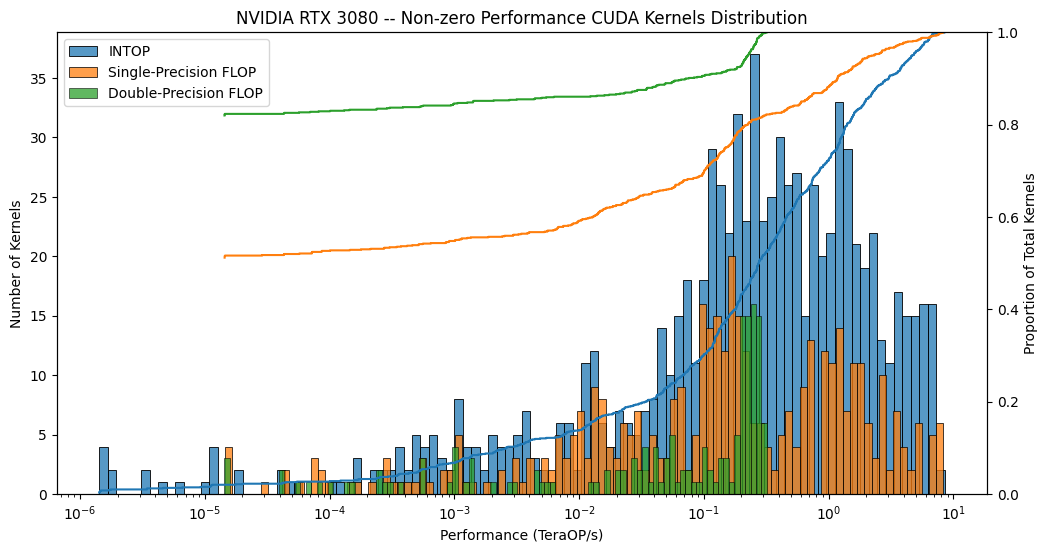

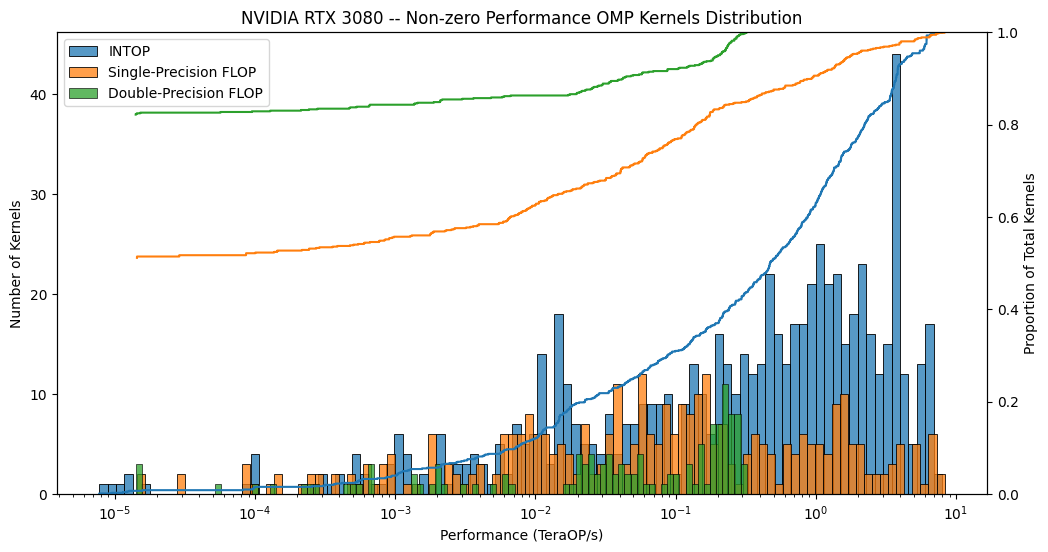

In [19]:
plotPerfHistogram(df, 'CUDA')
plotPerfHistogram(df, 'OMP')

### Visualize the Block and Grid Sizes

In [20]:
# because the sizes are in 3D, let's convert them to 1D by multiplying them


def strTupleTo1D(strTuple):
    finds = re.findall(r'\d+', strTuple)
    nums = [int(find) for find in finds]

    assert len(nums) == 3

    mult = 1
    for num in nums:
        mult = mult*num
    return mult


df['blockSz'] = df['Block Size'].apply(strTupleTo1D).astype(int)
df['gridSz'] = df['Grid Size'].apply(strTupleTo1D).astype(int)

print(df.head())


                                         Kernel Name       traffic      dpAI  \
0  haccmk_kernel(int, int, const float *, const f...  7.185577e+07  0.000000   
2  __omp_offloading_10309_2fc5ad7__Z11PushSpecies...  3.846578e+11  0.540417   
4  __omp_offloading_10309_2fc5ad7__Z14ScatterSpec...  1.802817e+09  0.000000   
6  __omp_offloading_10309_2fc5ad7__Z13RewindSpeci...  4.583011e+11  0.489803   
8  __omp_offloading_10309_2fc5ad7__Z14ScatterSpec...  8.413491e+09  0.573667   

          spAI    dpPerf    spPerf      xtime   Block Size     Grid Size  \
0  1860.420231  0.000000  0.133682  2990880.0  (256, 1, 1)     (4, 1, 1)   
2     0.043220  0.207876  0.016625    60128.0  (256, 1, 1)  (1954, 1, 1)   
4     0.000000  0.000000  0.000000     2272.0  (256, 1, 1)     (1, 1, 1)   
6     0.042581  0.224477  0.019515    51232.0  (256, 1, 1)  (1954, 1, 1)   
8     0.107668  0.004827  0.000906  1652736.0  (256, 1, 1)  (1954, 1, 1)   

                    device       intops   intPerf       intAI 

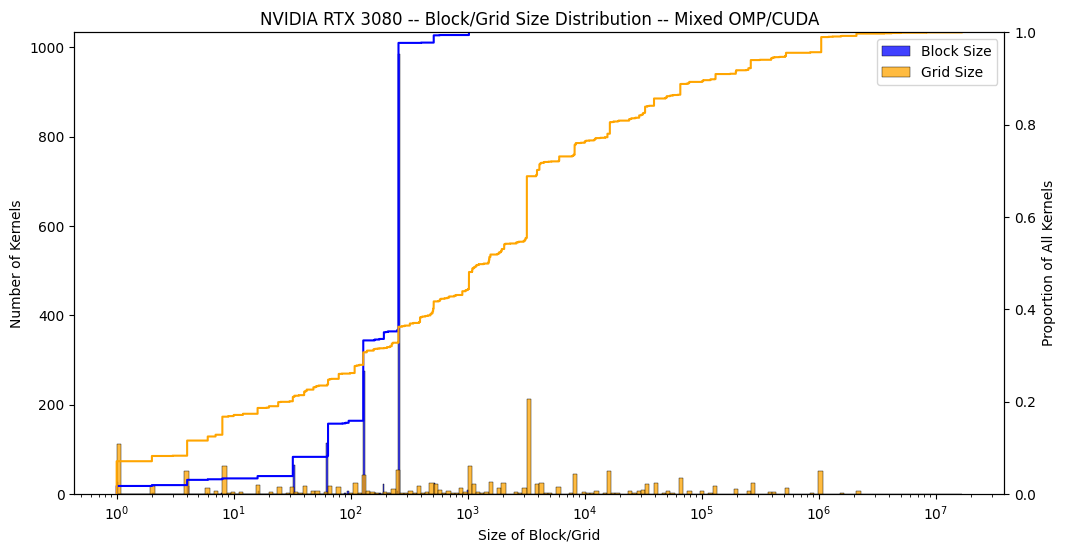

In [21]:

fig, ax = plt.subplots(1, figsize=(12,6))

sns.histplot(df, x='blockSz', bins=200, ax=ax, log_scale=True, color='blue')
#sns.histplot(df, x='blockSz', bins=100, ax=ax, log_scale=True, hue='language')
sns.histplot(df, x='gridSz', bins=200, ax=ax, log_scale=True, color='orange')
#sns.histplot(df, x='gridSz', bins=100, ax=ax, log_scale=True, hue='language')
ax2 = ax.twinx()
sns.ecdfplot(df, x='blockSz', ax=ax2, color='blue')
sns.ecdfplot(df, x='gridSz', ax=ax2, color='orange')
#sns.ecdfplot(df, x='blockSz', ax=ax2, hue='language')
#sns.ecdfplot(df, x='gridSz', ax=ax2, hue='language')

ax.set_xlabel('Size of Block/Grid')
ax.set_ylabel('Number of Kernels')
ax2.set_ylabel('Proportion of All Kernels')

ax.set_title(f'{gpuName} -- Block/Grid Size Distribution -- Mixed OMP/CUDA')

ax.legend(['Block Size', 'Grid Size'])
#ax2.legend()

plt.show()

In [22]:
# let's print the top 5 grid sizes and top 5 block sizes

#topBlockSzs = df.groupby('blockSz', 'language').count().reset_index().nlargest(5, ['language', 'Kernel Name', 'blockSz']).reset_index(drop=True)[['blockSz', 'Kernel Name']]
topn = 10

topBlockSzsJoined = df.groupby(['blockSz']).count().reset_index()
topBlockSzsOverall = topBlockSzsJoined.nlargest(topn, ['Kernel Name', 'blockSz'])[['Kernel Name', 'blockSz']]
numKernels = topBlockSzsJoined['Kernel Name'].sum()
topBlockSzsOverall['percent'] = 100*topBlockSzsOverall['Kernel Name']/numKernels

topBlockSzsOverall = topBlockSzsOverall.rename(columns={'Kernel Name':'Num Kernels'}).reset_index(drop=True)

display(topBlockSzsOverall)

topBlockSzs = df.groupby(['blockSz', 'language']).count().reset_index()#.nlargest(5, ['language', 'Kernel Name', 'blockSz'])

numKernelsCUDA = topBlockSzs[topBlockSzs['language'] == 'CUDA']['Kernel Name'].sum()
numKernelsOMP = topBlockSzs[topBlockSzs['language'] == 'OMP']['Kernel Name'].sum()

topBlockSzsCUDA = topBlockSzs[topBlockSzs['language'] == 'CUDA'].nlargest(topn, ['Kernel Name', 'blockSz'])[['language', 'Kernel Name', 'blockSz']]
topBlockSzsOMP = topBlockSzs[topBlockSzs['language'] == 'OMP'].nlargest(topn, ['Kernel Name', 'blockSz'])[['language', 'Kernel Name', 'blockSz']]

topBlockSzsCUDA['percent'] = 100*topBlockSzsCUDA['Kernel Name']/numKernelsCUDA
topBlockSzsOMP['percent'] = 100*topBlockSzsOMP['Kernel Name']/numKernelsOMP

topBlockSzsCUDA = topBlockSzsCUDA.rename(columns={'Kernel Name':'Num Kernels'}).reset_index(drop=True)
topBlockSzsOMP = topBlockSzsOMP.rename(columns={'Kernel Name':'Num Kernels'}).reset_index(drop=True)

display(topBlockSzsCUDA)
display(topBlockSzsOMP)


,Num Kernels,blockSz,percent
0,985,256,62.066793
1,276,128,17.391304
2,110,64,6.931317
3,66,32,4.158790
4,28,1,1.764335
5,25,512,1.575299
6,23,192,1.449275
7,18,4,1.134216
8,10,1024,0.630120
9,8,16,0.504096


,language,Num Kernels,blockSz,percent
0,CUDA,526,256,59.301015
1,CUDA,161,128,18.151071
2,CUDA,69,64,7.779030
3,CUDA,31,32,3.494927
4,CUDA,22,1,2.480271
5,CUDA,21,512,2.367531
6,CUDA,13,192,1.465614
7,CUDA,9,1024,1.014656
8,CUDA,9,4,1.014656
9,CUDA,4,96,0.450958


,language,Num Kernels,blockSz,percent
0,OMP,459,256,65.571429
1,OMP,115,128,16.428571
2,OMP,41,64,5.857143
3,OMP,35,32,5.000000
4,OMP,10,192,1.428571
5,OMP,9,4,1.285714
6,OMP,6,1,0.857143
7,OMP,4,512,0.571429
8,OMP,4,16,0.571429
9,OMP,3,96,0.428571


In [23]:
# let's print the top 5 grid sizes and top 5 block sizes

topn = 10
topGridSzs = df.groupby(['gridSz', 'language']).count().reset_index()#.nlargest(5, ['language', 'Kernel Name', 'gridSz'])

topgridSzsJoined = df.groupby(['gridSz']).count().reset_index()
topgridSzsOverall = topgridSzsJoined.nlargest(topn, ['Kernel Name', 'gridSz'])[['Kernel Name', 'gridSz']]
numKernels = topgridSzsJoined['Kernel Name'].sum()
topgridSzsOverall['percent'] = 100*topgridSzsOverall['Kernel Name']/numKernels

topgridSzsOverall = topgridSzsOverall.rename(columns={'Kernel Name':'Num Kernels'}).reset_index(drop=True)

display(topgridSzsOverall)

numKernelsCUDA = topGridSzs[topGridSzs['language'] == 'CUDA']['Kernel Name'].sum()
numKernelsOMP = topGridSzs[topGridSzs['language'] == 'OMP']['Kernel Name'].sum()

topGridSzsCUDA = topGridSzs[topGridSzs['language'] == 'CUDA'].nlargest(topn, ['Kernel Name', 'gridSz'])[['language', 'Kernel Name', 'gridSz']]
topGridSzsOMP = topGridSzs[topGridSzs['language'] == 'OMP'].nlargest(topn, ['Kernel Name', 'gridSz'])[['language', 'Kernel Name', 'gridSz']]

topGridSzsCUDA['percent'] = 100*topGridSzsCUDA['Kernel Name']/numKernelsCUDA
topGridSzsOMP['percent'] = 100*topGridSzsOMP['Kernel Name']/numKernelsOMP

topGridSzsCUDA = topGridSzsCUDA.rename(columns={'Kernel Name':'Num Kernels'}).reset_index(drop=True)
topGridSzsOMP = topGridSzsOMP.rename(columns={'Kernel Name':'Num Kernels'}).reset_index(drop=True)
display(topGridSzsCUDA)
display(topGridSzsOMP)


,Num Kernels,gridSz,percent
0,211,3200,13.295526
1,113,1,7.120353
2,62,8,3.906742
3,52,1048576,3.276623
4,52,256,3.276623
5,52,4,3.276623
6,48,1024,3.024575
7,43,128,2.709515
8,39,16384,2.457467
9,36,65536,2.268431


,language,Num Kernels,gridSz,percent
0,CUDA,77,1,8.680947
1,CUDA,32,65536,3.607666
2,CUDA,30,1024,3.382187
3,CUDA,30,8,3.382187
4,CUDA,27,256,3.043968
5,CUDA,26,16384,2.931229
6,CUDA,25,8192,2.818489
7,CUDA,24,39063,2.705750
8,CUDA,24,128,2.705750
9,CUDA,24,108,2.705750


,language,Num Kernels,gridSz,percent
0,OMP,211,3200,30.142857
1,OMP,42,4,6.000000
2,OMP,36,1,5.142857
3,OMP,34,1048576,4.857143
4,OMP,32,8,4.571429
5,OMP,25,256,3.571429
6,OMP,19,128,2.714286
7,OMP,18,1024,2.571429
8,OMP,13,16384,1.857143
9,OMP,10,512,1.428571


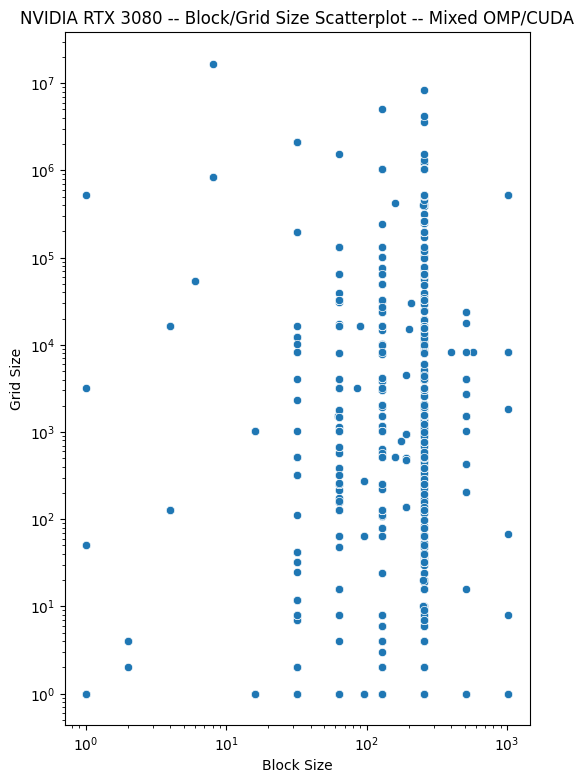

In [24]:

fig, ax = plt.subplots(1, figsize=(6,9))

sns.scatterplot(df, x='blockSz', y='gridSz', ax=ax)

ax.set_title(f'{gpuName} -- Block/Grid Size Scatterplot -- Mixed OMP/CUDA')
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Block Size')
ax.set_ylabel('Grid Size')

plt.show()

In [25]:
uniqBlockSzs = sorted(df['blockSz'].unique().tolist())
print(f'num unique block sizes: {len(uniqBlockSzs)}: {uniqBlockSzs}')

print()
uniqGridSzs = sorted(list(df['gridSz'].unique().tolist()))
print(f'num unique grid  sizes: {len(uniqGridSzs)}: {uniqGridSzs}')

num unique block sizes: 25: [1, 2, 4, 6, 8, 16, 32, 63, 64, 85, 90, 96, 128, 160, 176, 192, 200, 208, 250, 255, 256, 400, 512, 576, 1024]

num unique grid  sizes: 229: [1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 16, 19, 20, 24, 25, 30, 32, 33, 36, 40, 41, 42, 48, 50, 51, 53, 63, 64, 66, 68, 79, 84, 99, 108, 112, 118, 128, 137, 138, 157, 161, 169, 176, 193, 204, 216, 224, 225, 229, 255, 256, 257, 274, 288, 320, 343, 380, 384, 391, 400, 408, 435, 455, 480, 489, 500, 506, 511, 512, 560, 576, 578, 586, 588, 634, 669, 693, 768, 797, 899, 960, 1000, 1017, 1023, 1024, 1025, 1088, 1093, 1122, 1130, 1152, 1160, 1171, 1200, 1236, 1250, 1366, 1500, 1513, 1524, 1525, 1530, 1531, 1536, 1563, 1792, 1823, 1844, 1849, 1898, 1920, 1930, 1954, 2048, 2088, 2304, 2605, 2719, 2997, 3062, 3072, 3125, 3199, 3200, 3845, 3907, 3969, 4096, 4097, 4143, 4153, 4186, 4213, 4225, 4429, 4512, 4883, 5184, 6000, 6048, 7813, 8000, 8160, 8184, 8192, 8296, 8386, 9216, 10000, 10240, 10920, 12000, 12208, 12500, 13545, 14826, 15000, 15

## Read in the JSON files with the scraped kernels

In [26]:
import json
from pprint import pprint
from tqdm import tqdm

from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from autogen_core.models import UserMessage, SystemMessage, AssistantMessage
from autogen_core.model_context import UnboundedChatCompletionContext
from autogen_agentchat.agents import AssistantAgent

In [27]:
with open('simple-scraped-kernels-CUDA-pruned.json', 'r') as file:
    scrapedCUDA = json.load(file)

with open('simple-scraped-kernels-OMP-pruned.json', 'r') as file:
    scrapedOMP = json.load(file)


scrapedCodes = scrapedCUDA + scrapedOMP

In [28]:
pprint(scrapedCodes[0])

{'basename': 'accuracy-cuda',
 'exe': '/home/gbolet/hecbench-roofline/build/accuracy-cuda',
 'kernelNames': ['accuracy_kernel'],
 'kernels': {'accuracy_kernel': '-----------------------------------\n'
                                'reference.h\n'
                                '-----------------------------------\n'
                                'int reference (\n'
                                '    const int N,\n'
                                '    const int D,\n'
                                '    const int top_k,\n'
                                '    const float* Xdata,\n'
                                '    const int* labelData)\n'
                                '{\n'
                                '  int count = 0;\n'
                                '  for (int row = 0; row < N; row++) {\n'
                                '    const int label = labelData[row];\n'
                                '    const float label_pred = Xdata[row * D + '
                       

## Match up the kernels with their JSON and save to a file

In [29]:
def chat_history_to_json_line(ctxMessages:list):
    jsonDict = {'messages':[]}
    for msg in ctxMessages:
        if type(msg) == SystemMessage:
            role = 'system'
        elif type(msg) == UserMessage:
            role = 'user'
        elif type(msg) == AssistantMessage:
            role = 'assistant'
        else:
            assert False, f'Unknown message type: {type(msg)} of {msg}'
        content = msg.content

        jsonDict['messages'].append({'role':role, 'content':content})

    return json.dumps(jsonDict, allow_nan=False)

In [30]:
def makeJSONLine(systemMsg, kernelCode):
    sys_msg = SystemMessage(content=systemMsg)
    code_msg = UserMessage(source='User', content=f'```{kernelCode}```')
    context = UnboundedChatCompletionContext(initial_messages=[sys_msg, code_msg])

    messages = context.get_messages()
    jline = chat_history_to_json_line(messages)

    return f'{jline}\n'

In [ ]:
for idx, entry in enumerate(tqdm(scrapedCodes)):
    basename = entry['basename']
    exe = entry['exe']
    src = entry['src']
    kernelNames = entry['kernelNames']
    for kname in kernelNames:
        kernelCode = entry['kernels'][kname]
        # let's find the matching kernel data in the dataframe
        subdf = df[(df['targetName'] == basename) & (df['kernelName'] == kname)]
        numEntries = subdf.shape[0]

        if numEntries == 0:
            print(f'\tSKIPPING -- no entries for {basename}-[{kname}]')
            continue
        # if we got too many, it's most likely an error where the `kernelName`
        # matches for two entries, but the `Kernel Name` is actually different
        elif numEntries > 1:
            uniqueKNames = list(subdf['Kernel Name'].unique())
            assert len(uniqueKNames) == numEntries
            

        assert numEntries == 1, f'num entries for {basename}-[{kname}]: {numEntries}\n\n {subdf}'

  1%|▏         | 8/539 [00:00<00:00, 1003.42it/s]


AssertionError: num entries for aidw-cuda-[AIDW_Kernel]: 2

                                             Kernel Name      traffic  dpAI  \
1299  AIDW_Kernel(const float *, const float *, cons...  78046762.56   0.0   
1300  AIDW_Kernel_Tiled(const float *, const float *...  94958861.77   0.0   

              spAI  dpPerf    spPerf      xtime   Block Size   Grid Size  \
1299  26055.523837     0.0  2.033549  3713056.0  (256, 1, 1)  (40, 1, 1)   
1300  28238.298556     0.0  2.681477  2815872.0  (256, 1, 1)  (40, 1, 1)   

                       device        intops   intPerf        intAI targetName  \
1299  NVIDIA GeForce RTX 3080  1.678029e+09  0.451927  5790.459364  aidw-cuda   
1300  NVIDIA GeForce RTX 3080  1.263596e+09  0.448740  4725.629488  aidw-cuda   

       exeArgs   kernelName language  blockSz  gridSz  
1299  10 1 100  AIDW_Kernel     CUDA      256      40  
1300  10 1 100  AIDW_Kernel     CUDA      256      40  